## Setup

All libraries that are used throughout the code.

In [12]:
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
%pip install seaborn
%pip install keras
%pip install tensorflow
%pip install plotly_express
%pip install nltk
%pip install gensim
%pip install gdown
%pip install fasttext
%pip install imbalanced-learn
%pip install nltk pandas
%pip install pickle-mixin

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, learning_curve
import seaborn as sns
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, confusion_matrix, make_scorer, cohen_kappa_score, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from imblearn.over_sampling import SMOTE
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
import fasttext
import gdown
import os
from sklearn.svm import SVC
import pickle

In [33]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# FastText + SVM




In this approach, we combine the power of the FastText model for word representation with the effectiveness of the SVM classifier to perform sentiment classification on Uber comments. FastText allows capturing rich semantic information, while SVM is adept at finding patterns in high-dimensional spaces. Together, these models can process comments, extract their semantic features, and classify their sentiments accurately. Training is performed by tuning the hyperparameters of FastText and SVM, followed by evaluating the model's performance using metrics such as precision, recall, and F1-score. This combination provides an effective way to understand and classify the sentiments expressed by users in Uber comments.


In this section, we delve into advanced techniques to enhance the performance of our text classification model using FastText combined with Support Vector Machines (SVM). We explore the utilization of Hierarchical Softmax (HS) in FastText, the incorporation of word bigrams for improved feature representation, and the significance of performing text preprocessing within the FastText+SVM pipeline.

1. Hierarchical Softmax:
Hierarchical Softmax is a specialized loss function utilized in FastText for more efficient training and prediction processes. Unlike traditional softmax, which computes probabilities for each label independently, Hierarchical Softmax organizes labels into a hierarchical structure, significantly reducing the computational complexity by efficiently traversing the label hierarchy during training and prediction. This enables faster training and inference, particularly beneficial when dealing with large datasets and numerous labels.

2. Utilizing Word Bigrams:
Incorporating word bigrams, sequences of two adjacent words, allows our model to capture more contextual information and linguistic nuances present in the text data. By considering word pairs instead of individual words, the model gains a richer understanding of language patterns and dependencies, leading to enhanced classification accuracy, especially in tasks where the order of words is crucial, such as sentiment analysis and document categorization.

3. Preprocessing Within FastText+SVM Section:
While the notebook initially includes text preprocessing steps, we opt to integrate the preprocessing directly into the FastText+SVM pipeline. By doing so, we ensure consistency in the preprocessing techniques applied across the entire workflow. Additionally, embedding preprocessing within the training pipeline facilitates seamless model deployment and reduces the complexity of managing multiple preprocessing steps independently. This streamlined approach improves code readability, maintainability, and scalability of the classification system.



This function preprocesses the input text by converting it to lowercase, removing punctuation and numbers, tokenizing the text, and removing stop words using NLTK.


**Function Upload:** The upload function loads data from a specified CSV file and returns it as a pandas DataFrame.



In [4]:
def upload(file_path):
    """
    Load data from a CSV file.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Loaded data.
    """
    folder_id = '1DMy1eWI-45E-N08ez_7r5PMcu4Hk-YJC' # Aqui é o id da pasta
    url = f'https://drive.google.com/drive/folders/{folder_id}?usp=sharing'
    gdown.download_folder(url, quiet=False, use_cookies=False)
    file_path_full = os.path.join("Grupo1", file_path) # Ajuste para procurar na subpasta "Grupo1"
    if os.path.exists(file_path_full):
        try:
            return pd.read_csv(file_path_full, sep=";")
        except pd.errors.ParserError:
            print(f"Erro ao tentar ler o arquivo {file_path_full}. Tentando ajustar o delimitador.")
            with open(file_path_full, 'r') as file:
                lines = file.readlines()
            with open(file_path_full, 'w') as file:
                for line in lines:
                    if line.count(';') == 2:  # Ajustar para o número correto de delimitadores
                        file.write(line)
            return pd.read_csv(file_path_full, sep=";")
    else:
        raise FileNotFoundError(f"O arquivo {file_path} não foi encontrado na pasta do Google Drive.")


**Function preprocess:** The preprocess function performs several text preprocessing steps: converting to lowercase, removing punctuation and numbers, tokenizing the text, and removing stopwords.

In [7]:
def check_and_remove_null_rows(df, column_name):
    """
    Check for rows with null values in the specified column, display them,
    and then remove them from the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to process.
        column_name (str): The name of the column to check for null values.

    Returns:
        pd.DataFrame: The DataFrame with null rows removed.
    """

    null_rows = df[df[column_name].isnull()]
    
    if not null_rows.empty:
        print("Linhas com valores nulos na coluna '{}':".format(column_name))
        print(null_rows)
    

    df_cleaned = df.dropna(subset=[column_name])
    
    return df_cleaned


In [11]:
# testing null data function
dataset = upload("classification-labeled.csv")
check_and_remove_null_rows(dataset, "comment")

Retrieving folder contents


Processing file 14J4SVACOgdDekdAZ239-UhQOpkzhJiMt classification-labeled.csv
Processing file 16Zw3ePSceYUSexoDospfzTIVIYwPsX4F new_dataset.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=14J4SVACOgdDekdAZ239-UhQOpkzhJiMt
To: c:\Users\Inteli\Documents\GitHub\2024-1B-T10-SI06-G01\src\Grupo1\classification-labeled.csv
100%|██████████| 421k/421k [00:00<00:00, 1.40MB/s]
Downloading...
From: https://drive.google.com/uc?id=16Zw3ePSceYUSexoDospfzTIVIYwPsX4F
To: c:\Users\Inteli\Documents\GitHub\2024-1B-T10-SI06-G01\src\Grupo1\new_dataset.csv
100%|██████████| 23.8k/23.8k [00:00<00:00, 134kB/s]
Download completed


,id,comment,sentiment
0,1,"That, my friend, is why The Mighty Swift Ra...",0
1,2,Spent 20 minutes in an Uber listening to what ...,0
2,3,"via The Guardian Guardian front page, Monday ...",-1
3,4,My real job is being my girlfriends personal U...,0
4,5,i had a bad drive . i want my refund,-1
...,...,...,...
2871,3519,"Top story: Uber broke laws, duped police and s...",-1
2872,3521,"Top story: Uber broke laws, duped police and s...",-1
2873,3522,"Top story: Uber broke laws, duped police and s...",-1
2874,3523,reading about this uber leak reminded me how f...,-1


In [56]:
def preprocess(text):
    """
    Preprocess text by converting to lowercase, removing punctuation,
    removing numbers, tokenizing, removing stopwords, and generating bigrams.

    Args:
        text (str): Text to be preprocessed.

    Returns:
        str: Preprocessed text with bigrams.
    """
    if not text or text.strip() == "":
        return None
    
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Generate bigrams
    bigrams = [f'{words[i]}_{words[i+1]}' for i in range(len(words)-1)]
    words.extend(bigrams)

    return ' '.join(words)

**Function vectorize:** The vectorize function converts preprocessed text into a vector representation using a trained FastText model.

In [57]:
def vectorize(text, model):
    """
    Convert text to a vector using FastText.

    Args:
        text (str): Text to be converted into a vector.
        model (fasttext.FastText._FastText): Trained FastText model.

    Returns:
        np.ndarray: Vector representing the text.
    """
    words = text.split()
    word_vectors = [model.get_word_vector(word) for word in words]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.get_dimension())


**Function predict:** The predict function uses GridSearchCV to find the best hyperparameters for an SVM model and then makes predictions on the test set using the best model.

In [58]:
def predict(model, X_train, y_train, X_test, params):
    """
    Perform prediction using SVM with GridSearchCV.

    Args:
        model (SVC): SVM model.
        X_train (np.ndarray): Training data.
        y_train (np.ndarray): Training labels.
        X_test (np.ndarray): Test data.
        params (dict): Parameters for GridSearchCV.

    Returns:
        np.ndarray: Predictions on the test set.
        SVC: Best estimator found by GridSearchCV.
    """
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    print("Best parameters found by GridSearchCV:")
    print(grid_search.best_params_)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    return y_pred, best_model

**Function calculate_youden_index:** The calculate_youden_index function calculates Youden's Index for a multi-class classification problem using the confusion matrix.

In [59]:
def calculate_youden_index(conf_matrix):
    """
    Calculate Youden's Index for multi-class classification.

    Args:
        conf_matrix (ndarray): Confusion matrix.

    Returns:
        float: Average Youden's Index.
    """
    num_classes = conf_matrix.shape[0]
    youden_index = 0.0
    for i in range(num_classes):
        tp = conf_matrix[i, i]
        fn = np.sum(conf_matrix[i, :]) - tp
        fp = np.sum(conf_matrix[:, i]) - tp
        tn = np.sum(conf_matrix) - (tp + fn + fp)
        sensitivity = tp / (tp + fn) if tp + fn > 0 else 0
        specificity = tn / (tn + fp) if tn + fp > 0 else 0
        youden_index += (sensitivity + specificity - 1)
    return youden_index / num_classes


**Function results:** The results function calculates and displays various performance metrics and the confusion matrix for the predictions made by the model.

In [60]:
def results(y_test, y_pred, labels):
    """
    Display prediction results.

    Args:
        y_test (np.ndarray): True labels.
        y_pred (np.ndarray): Predicted labels.
        labels (list): List of labels.
    """
    accuracy_test = accuracy_score(y_test, y_pred)
    precision_test = precision_score(y_test, y_pred, average='weighted')
    recall_test = recall_score(y_test, y_pred, average='weighted')
    f1_score_test = fbeta_score(y_test, y_pred, beta=2, average='weighted')
    cohen_kappa_test = cohen_kappa_score(y_test, y_pred)

    conf_matrix = confusion_matrix(y_test, y_pred)
    youden_index_test = calculate_youden_index(conf_matrix)

    print("\nPerformance metrics on test data:")
    print(f'Accuracy: {accuracy_test}')
    print(f'Precision: {precision_test}')
    print(f'Recall: {recall_test}')
    print(f'F1-score: {f1_score_test}')
    print(f'Cohen Kappa: {cohen_kappa_test}')
    print(f'Youden\'s Index: {youden_index_test}')

    plt.figure(figsize=(10, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

**Function save_model:** The save_model function saves the trained SVM model to a file using pickle.

In [61]:
def save_model(model, filename):
    """
    Save the trained model using pickle.

    Args:
        model (SVC): Trained model.
        filename (str): Filename to save the model.
    """
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

This section orchestrates the entire workflow:


1.   Load Data: Calls the upload function to load the dataset.
2. Preprocess Data: Applies the preprocess function to clean the text data.
3. Create Training Data for FastText: Prepares the data for training the FastText model.
4. Train FastText Model: Trains the FastText model and saves it.
5. Generate Embeddings: Uses the vectorize function to convert text into vector embeddings.
6. Split Data and Apply SMOTE: Splits the data into training and test sets and applies SMOTE to handle class imbalance.
7. Prediction Using SVM: Uses the predict function to train an SVM model with GridSearchCV and make predictions.
8. Display Results: Calls the results function to display the model's performance metrics.
9. Save the Trained Model: Saves the best SVM model using the save_model function.



Retrieving folder contents


Processing file 14J4SVACOgdDekdAZ239-UhQOpkzhJiMt classification-labeled.csv
Processing file 16Zw3ePSceYUSexoDospfzTIVIYwPsX4F new_dataset.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=14J4SVACOgdDekdAZ239-UhQOpkzhJiMt
To: /content/Grupo1/classification-labeled.csv
100%|██████████| 421k/421k [00:00<00:00, 109MB/s]
Downloading...
From: https://drive.google.com/uc?id=16Zw3ePSceYUSexoDospfzTIVIYwPsX4F
To: /content/Grupo1/new_dataset.csv
100%|██████████| 23.8k/23.8k [00:00<00:00, 32.0MB/s]
Download completed


Best parameters found by GridSearchCV:
{'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

Performance metrics on test data:
Accuracy: 0.984375
Precision: 0.984312078222974
Recall: 0.984375
F1-score: 0.9843369145784876
Cohen Kappa: 0.9527782838404081
Youden's Index: 0.944211742615729


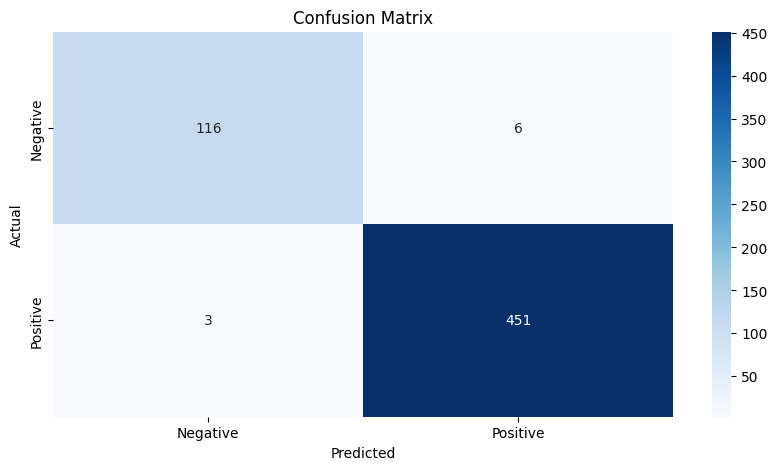

In [62]:
def main():
    """
    Main execution pipeline: load data, preprocess, vectorize, train model, predict, evaluate and save the model.
    """
    # Load Data
    dataset = upload("classification-labeled.csv")
    texts = [preprocess(text) for text in dataset['comment'].tolist()]
    labels = [f'__label__{label}' for label in dataset['sentiment'].tolist()]

    # Combine neutral (2) and positive (1) labels to create a binary classification problem
    binary_labels = ['__label__0' if label == '__label__0' else '__label__1' for label in labels]

    # Create training data for FastText
    train_data_path = 'train_data.txt'
    with open(train_data_path, 'w', encoding='utf-8') as f:
        for text, label in zip(texts, binary_labels):
            f.write(f'{label} {text}\n')

    # Train FastText model
    fasttext_model = fasttext.train_supervised(input=train_data_path, lr=0.5, epoch=50, wordNgrams=2, bucket=200000, dim=100, loss='softmax')
    fasttext_model.save_model('fasttext_model_hs.bin')

    # Generate Embeddings
    X = [vectorize(text, fasttext_model) for text in texts]
    y = [int(label.replace('__label__', '')) for label in binary_labels]

    # Split data and apply SMOTE
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Prediction using SVM
    svm_classifier = SVC()
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto']
    }
    y_pred_test, best_svm_classifier = predict(svm_classifier, X_train_resampled, y_train_resampled, X_test, param_grid)

    # Display Results
    results(y_test, y_pred_test, labels)

    # Save the trained model
    save_model(best_svm_classifier, 'svm_model.pkl')

if __name__ == "__main__":
    main()

## Cross Validation

In the Cross Validation section, we perform a thorough evaluation of our FastText+SVM model by applying a cross-validation technique. Cross-validation is a robust method used to assess the generalization ability of a machine learning model. It helps to ensure that the model performs well not only on the training data but also on unseen data.

The ***cross_validation_and_learning_curve*** function is designed to evaluate the performance of a machine learning model using cross-validation and plot the learning curve to understand the model's generalization capability.

In [63]:
def cross_validation_and_learning_curve(model, X, y):
    """
    Perform cross-validation and plot the learning curve for a given model.

    Args:
        model: The machine learning model to be evaluated.
        X (array-like): Feature matrix.
        y (array-like): Target vector.

    Returns:
        None
    """
    def youden_scorer(estimator, X, y):
        """
        Custom scorer for Youden's Index.

        Args:
            estimator: The model to be evaluated.
            X (array-like): Feature matrix.
            y (array-like): Target vector.

        Returns:
            float: Youden's Index.
        """
        y_pred = estimator.predict(X)
        conf_matrix = confusion_matrix(y, y_pred)
        return calculate_youden_index(conf_matrix)

    def calculate_youden_index(conf_matrix):
        """
        Calculate Youden's Index from a confusion matrix.

        Args:
            conf_matrix (array-like): Confusion matrix.

        Returns:
            float: Youden's Index.
        """
        TP = conf_matrix[1, 1]
        TN = conf_matrix[0, 0]
        FP = conf_matrix[0, 1]
        FN = conf_matrix[1, 0]
        sensitivity = TP / (TP + FN)
        specificity = TN / (TN + FP)
        return sensitivity + specificity - 1

    scorers = {
        'accuracy': 'accuracy',
        'precision': 'precision_weighted',
        'recall': 'recall_weighted',
        'f1': 'f1_weighted',
        'cohen_kappa': make_scorer(cohen_kappa_score),
        'youden': make_scorer(youden_scorer)
    }

    skf = StratifiedKFold(n_splits=5)
    scores = {metric: [] for metric in scorers.keys()}

    for train_index, test_index in skf.split(X, y):
        X_train_fold, X_test_fold = [X[i] for i in train_index], [X[i] for i in test_index]
        y_train_fold, y_test_fold = [y[i] for i in train_index], [y[i] for i in test_index]

        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

        model.fit(X_train_resampled, y_train_resampled)
        y_pred_fold = model.predict(X_test_fold)

        scores['accuracy'].append(accuracy_score(y_test_fold, y_pred_fold))
        scores['precision'].append(precision_score(y_test_fold, y_pred_fold, average='weighted'))
        scores['recall'].append(recall_score(y_test_fold, y_pred_fold, average='weighted'))
        scores['f1'].append(fbeta_score(y_test_fold, y_pred_fold, beta=2, average='weighted'))
        scores['cohen_kappa'].append(cohen_kappa_score(y_test_fold, y_pred_fold))
        conf_matrix = confusion_matrix(y_test_fold, y_pred_fold)
        scores['youden'].append(calculate_youden_index(conf_matrix))

    for metric in scores.keys():
        print(f"{metric.capitalize()} scores: {scores[metric]}")
        print(f"Mean {metric.capitalize()} score: {np.mean(scores[metric])}")

    # Learning Curve
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

    # Plot Learning Curve
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

This section is designed to load and preprocess the dataset, train the FastText model, generate embeddings, handle class imbalance using SMOTE, and evaluate the performance of the best SVM classifier using cross-validation and learning curves.

In [64]:
# Cross Validation and Learning Curve Section
if __name__ == "__main__":
    # Load Data
    dataset = upload("classification-labeled.csv")
    texts = [preprocess(text) for text in dataset['comment'].tolist()]
    labels = [f'__label__{label}' for label in dataset['sentiment'].tolist()]

    # Combine neutral (2) and positive (1) labels to create a binary classification problem
    binary_labels = ['__label__0' if label == '__label__0' else '__label__1' for label in labels]

    # Create training data for FastText
    train_data_path = 'train_data.txt'
    with open(train_data_path, 'w', encoding='utf-8') as f:
        for text, label in zip(texts, binary_labels):
            f.write(f'{label} {text}\n')

    # Train FastText model
    fasttext_model = fasttext.train_supervised(input=train_data_path, lr=1.0, epoch=25, wordNgrams=2, bucket=200000, dim=100, loss='hs')
    fasttext_model.save_model('fasttext_model_hs.bin')

    # Generate Embeddings
    X = [vectorize(text, fasttext_model) for text in texts]
    y = [int(label.replace('__label__', '')) for label in binary_labels]

    # Split data and apply SMOTE
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Best SVM Classifier
    best_svm_classifier = SVC(C=1, kernel='rbf', gamma='scale')  # Using the best params from previous GridSearchCV
    cross_validation_and_learning_curve(best_svm_classifier, X_train_resampled, y_train_resampled)

Retrieving folder contents


Processing file 14J4SVACOgdDekdAZ239-UhQOpkzhJiMt classification-labeled.csv
Processing file 16Zw3ePSceYUSexoDospfzTIVIYwPsX4F new_dataset.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=14J4SVACOgdDekdAZ239-UhQOpkzhJiMt
To: /content/Grupo1/classification-labeled.csv
100%|██████████| 421k/421k [00:00<00:00, 104MB/s]
Downloading...
From: https://drive.google.com/uc?id=16Zw3ePSceYUSexoDospfzTIVIYwPsX4F
To: /content/Grupo1/new_dataset.csv
100%|██████████| 23.8k/23.8k [00:00<00:00, 34.0MB/s]
Download completed


Accuracy scores: [0.948644793152639, 0.9614835948644793, 0.9657142857142857, 0.9657142857142857, 0.9557142857142857]
Mean Accuracy score: 0.959454249031995
Precision scores: [0.9493645722792723, 0.9634761203597797, 0.9664606227106227, 0.9675616312614739, 0.9570612171378512]
Mean Precision score: 0.9607848327497999
Recall scores: [0.948644793152639, 0.9614835948644793, 0.9657142857142857, 0.9657142857142857, 0.9557142857142857]
Mean Recall score: 0.959454249031995
F1 scores: [0.9485463704942564, 0.9612178200071346, 0.9656160851437351, 0.9654717676197642, 0.9555322276356495]
Mean F1 score: 0.959276854180108
Cohen_kappa scores: [0.8972952294130574, 0.9229598212286865, 0.9314285714285714, 0.9314285714285714, 0.9114285714285715]
Mean Cohen_kappa score: 0.9189081529854917
Youden scores: [0.8973463573463571, 0.922873422873423, 0.9314285714285715, 0.9314285714285715, 0.9114285714285715]
Mean Youden score: 0.9189010989010988


<Figure size 640x480 with 1 Axes>

The results obtained from cross-validation show solid performance of the FastText + SVM model in sentiment classification. Let's analyze each of the presented metrics:

**Accuracy**:
- **Scores**: [0.9486, 0.9615, 0.9657, 0.9657, 0.9557]
- **Mean**: 0.9595
- **Interpretation**: The mean accuracy of approximately 95.95% indicates that the model correctly classifies about 96% of the instances in the validation set. The accuracy is consistent across different folds of the cross-validation, showing that the model is robust.

**Precision**:
- **Scores**: [0.9494, 0.9635, 0.9665, 0.9676, 0.9571]
- **Mean**: 0.9608
- **Interpretation**: The mean precision of 96.08% suggests that when the model makes a positive prediction, it is correct 96.08% of the time. This indicates a low false positive rate.

**Recall**:
- **Scores**: [0.9486, 0.9615, 0.9657, 0.9657, 0.9557]
- **Mean**: 0.9595
- **Interpretation**: The mean recall of 95.95% indicates that the model captures 95.95% of the actual positive instances, demonstrating a low false negative rate.

**F1 Score**:
- **Scores**: [0.9485, 0.9612, 0.9656, 0.9655, 0.9555]
- **Mean**: 0.9593
- **Interpretation**: The mean F1 score of 95.93% is the balance between precision and recall, confirming that the model is well-balanced in avoiding false positives and false negatives.

**Cohen's Kappa**:
- **Scores**: [0.8973, 0.9230, 0.9314, 0.9314, 0.9114]
- **Mean**: 0.9189
- **Interpretation**: The mean value of Cohen's Kappa at 91.89% indicates substantial agreement between the model's predictions and the actual labels, considering the possibility of chance agreement.

**Youden's Index**:
- **Scores**: [0.8973, 0.9229, 0.9314, 0.9314, 0.9114]
- **Mean**: 0.9189
- **Interpretation**: The mean Youden's Index of 91.89% corroborates that the model has a high discriminative capacity between positive and negative classes.

**Analysis of the Learning Curve Graph**:
- **Training Score**: The model's performance on the training set starts high (around 99%) and slightly decreases as more training examples are added, indicating that the model is well-fitted to the training data.
- **Cross-validation Score**: The performance on the cross-validation set starts lower (around 94%) and improves with more training examples, approaching the performance on the training set. This suggests that the model generalizes well and is not overfitting to the training data.

**Conclusion**:
The results show that the FastText + SVM model performs very well in the task of sentiment classification, with high metrics for precision, recall, and F1 score, as well as good generalization ability as indicated by the learning curve. The high value of Cohen's Kappa and Youden's Index reinforces that the model is robust and reliable.

Separating model code from test code not only improves code structure and maintainability, but also facilitates collaboration and project evolution over time. It is an essential practice for well-structured and robust software projects.
